# **Setup**

In [ ]:
pip install -U bitsandbytes datasets optuna matplotlib nltk mistralai transformers huggingface_hub numpy torch pandas seaborn

In [2]:
from mistralai import Mistral
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline, GPT2LMHeadModel, GPT2TokenizerFast
from huggingface_hub import hf_hub_download, notebook_login, login
from datasets import load_dataset
import numpy as np
import torch
import time
import re
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import json
import os
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
os.environ["TORCHDYNAMO_DISABLE"] = "1"

#login(token="your_huggingface_api_token")  # Replace with your actual API token

quant_config = BitsAndBytesConfig(load_in_8bit=True)

model_id = "google/gemma-2-2b-it"

torch.set_grad_enabled(False) # avoid blowing up mem

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map='auto',
    quantization_config=quant_config
)

torch.cuda.empty_cache()  # Frees up unused memory that has been allocated by PyTorch

tokenizer =  AutoTokenizer.from_pretrained("google/gemma-2-2b-it")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

# **Initial Inference: Gemma-2-2B-IT on SimpleQA**
Generate base responses from the instruction-tuned Gemma-2-2B-IT model for the first 500 SimpleQA prompts. These outputs serve as the foundation for filtering, enrichment, and steering.

**Note:** This step may take some time. Precomputed outputs are already included and used for evaluation, so re-execution is not necessary. This cell was intentionally not run to save time.

In [ ]:
# Load SimpleQA dataset (top 500 rows)
dataset = load_dataset("basicv8vc/SimpleQA", split="test[:500]")
simpleqa_df = pd.DataFrame(dataset)  # Columns: metadata, problem, answer

# Output container
results = []

for idx, row in simpleqa_df.iterrows():
    question = row["problem"]
    ground_truth = row["answer"]

    prompt = f"Question: {question}\nAnswer:"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_new_tokens=100, temperature=0.0)
        response = tokenizer.decode(output[0], skip_special_tokens=True)

    results.append({
        "prompt": question,
        "response": response,
        "ground_truth": ground_truth
    })

# Save results
pd.DataFrame(results).to_csv("simpleqa_initial_outputs.csv", index=False)
print("Responses saved.")

# **SimpleQA Filtering Grader**
## LLM Grader 1: SimpleQA Filtering
Functions used to triage base model predictions as CORRECT / INCORRECT / NOT_ATTEMPTED.

(create_grader_prompt, grade_with_mistral)

This grader was used to filter the 500 SimpleQA examples down to the 260 incorrect cases.
It assigns one of three labels: `CORRECT`, `INCORRECT`, or `NOT_ATTEMPTED`, following a rubric-driven template.


In [5]:
# ----------------------------
# Configuration for Mistral API
# ----------------------------
#MISTRAL_API_KEY = "your_mistral_api_key"  # Replace with your actual API key
GRADER_MODEL = "mistral-small-latest"      # Replace if needed
TEMPERATURE = 0.0                          # Use 0 for deterministic output

# Initialize the Mistral client
client = Mistral(api_key=MISTRAL_API_KEY)

# ----------------------------
# Grader Template
# ----------------------------
GRADER_TEMPLATE = """
You are a factuality grader. Given a question, a gold target (correct answer), and a predicted answer, assign one of the following grades:
- "CORRECT" (fully contains correct information, no contradictions)
- "INCORRECT" (contains incorrect, misleading, or contradictory information)
- "NOT_ATTEMPTED" (fails to answer or provides irrelevant information)

### Example Grades:
CORRECT:
- Question: "Who discovered gravity?"
  - Gold target: "Isaac Newton"
  - Predicted: "Isaac Newton"
  - Predicted: "Newton discovered gravity."
  - Predicted: "Most believe Isaac Newton discovered gravity."

INCORRECT:
- Question: "Who discovered gravity?"
  - Gold target: "Isaac Newton"
  - Predicted: "Albert Einstein"
  - Predicted: "Newton, Einstein, and Galileo discovered gravity." (Contradicts correct answer)
  - Predicted: "Gravity was first theorized in 1905." (Incorrect)

NOT_ATTEMPTED:
- Question: "Who discovered gravity?"
  - Gold target: "Isaac Newton"
  - Predicted: "I don't know."
  - Predicted: "It depends on interpretation."
  - Predicted: "Without more context, I cannot say."

### Rules:
- Ignore capitalization, punctuation, and grammar differences.
- Allow hedging (e.g., "I think" or "probably") as long as the correct answer is included.
- If a predicted answer partially matches but is missing key details, grade as INCORRECT.
- If a number is the correct answer, it must be accurate to the last significant figure.
- Do not punish minor typos in names if the intent is clear.

### Now, grade this:
Question: {question}
Gold target: {target}
Predicted answer: {predicted_answer}

Reply with:
A: CORRECT
B: INCORRECT
C: NOT_ATTEMPTED

Only return "A", "B", or "C" with no extra text.
""".strip()

In [6]:
# ----------------------------
# Helper Functions
# ----------------------------
def create_grader_prompt(question: str, target: str, predicted_answer: str) -> str:
    """Formats the grader prompt with the provided question, target, and predicted answer."""
    return GRADER_TEMPLATE.format(
        question=question,
        target=target,
        predicted_answer=predicted_answer
    )

def grade_with_mistral(question: str, target: str, predicted_answer: str, retries=3, base_delay=2) -> str:
    """
    Sends the grader prompt to Mistral and extracts the grade letter (A, B, or C).
    Implements retry logic with exponential backoff in case of rate limits.

    - retries: Number of retry attempts before failing.
    - base_delay: Base wait time before retrying (in seconds).
    """
    for attempt in range(retries):
        try:
            prompt = create_grader_prompt(question, target, predicted_answer)

            # Prepare chat messages
            messages = [
                {"role": "system", "content": "You are a grading assistant."},
                {"role": "user", "content": prompt}
            ]

            # Call Mistral's API
            chat_response = client.chat.complete(
                model=GRADER_MODEL,
                temperature=TEMPERATURE,
                messages=messages
            )

            # Extract grade from response
            output = chat_response.choices[0].message.content
            match = re.search(r"(A|B|C)", output)
            return match.group(0) if match else "C"  # Default to "NOT_ATTEMPTED"

        except Exception as e:
            if "Requests rate limit exceeded" in str(e):
                wait_time = base_delay * (2 ** attempt) + (attempt * 0.5)  # Exponential backoff
                print(f"Rate limit hit. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
            else:
                print(f"Error during API call: {e}")
                return "C"  # Default to "NOT_ATTEMPTED"

# **Reference Enrichment**

For each failure case, we prompt the base model with both the question and its ground-truth answer to elicit a complete, natural response—often including an explanation. These enriched outputs serve as the reference samples from which we later extract steering activations. Metadata, including the explanation (if present), is saved for analysis and reproducibility.

**Note:** This step may take some time. Precomputed outputs are already included and used for evaluation, so re-execution is not necessary. This cell was intentionally not run to save time.

In [ ]:
# ----------------------------------------
# Corrected Response Generation & Metadata Capture
# ----------------------------------------

# File paths
output_dir = "output_data"
os.makedirs(output_dir, exist_ok=True)

output_csv = os.path.join(output_dir, "corrected_responses.csv")
output_json = os.path.join(output_dir, "corrected_metadata.json")

# Prompt template for natural, guided response
CORRECT_RESPONSE_TEMPLATE = """
Question: {question}
Answer: {target}
""".strip()

def create_correct_response_prompt(question: str, target: str) -> str:
    return CORRECT_RESPONSE_TEMPLATE.format(question=question, target=target)

# Load prompts where base model failed
df_incorrect = pd.read_csv("incorrect.csv")  # columns: prompt, response, ground_truth

# Init output containers
corrected_metadata = []
corrected_csv_rows = []
save_every = 10

# Process each prompt
for idx, row in df_incorrect.iterrows():
    question = row["prompt"]
    ground_truth = row["ground_truth"]

    prompt_text = create_correct_response_prompt(question, ground_truth)
    input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to("cuda")

    # Generate full response (answer + explanation)
    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, max_new_tokens=100)
        corrected_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Split explanation if present
    if "**Explanation:**" in corrected_response:
        qa_text, explanation_text = corrected_response.split("**Explanation:**", 1)
        qa_text = qa_text.strip()
        explanation_text = explanation_text.strip()
    else:
        qa_text = corrected_response.strip()
        explanation_text = ""

    # Save metadata
    corrected_metadata.append({
        "prompt": question,
        "ground_truth": ground_truth,
        "corrected_response": qa_text,
        "explanation": explanation_text
    })

    # Save to CSV row
    csv_row = {
        "prompt": question,
        "ground_truth": ground_truth,
        "corrected_response": qa_text,
        "explanation": explanation_text
    }
    corrected_csv_rows.append(csv_row)

    # Periodic save
    if (idx + 1) % save_every == 0:
        with open(output_json, "w") as f:
            json.dump(corrected_metadata, f)
        pd.DataFrame(corrected_csv_rows).to_csv(output_csv, index=False)
        print(f"Checkpoint saved at row {idx + 1}")

# Final save
with open(output_json, "w") as f:
    json.dump(corrected_metadata, f)
pd.DataFrame(corrected_csv_rows).to_csv(output_csv, index=False)
print("Final Save Complete!")

# **Reference Activation Extraction**

This section extracts reference activation vectors for each prompt-layer pair using the enriched prompt (question + ground truth + explanation). We store one averaged vector per layer for each prompt. Vectors are periodically checkpointed for fault tolerance.

In [8]:
def extract_reference_vector(prompt, gt, exp, model, tokenizer, layer_id):
    full_prompt = f"Question: {prompt}\nAnswer and explanation:\n{gt}\n{exp}"
    encoded = tokenizer(full_prompt, return_offsets_mapping=True, return_tensors="pt", add_special_tokens=True)
    input_ids = encoded["input_ids"].to("cuda")
    offsets = encoded["offset_mapping"][0]  # [seq_len, 2]

    gt_start = full_prompt.find(gt)
    gt_end = gt_start + len(gt) + len(exp)

    # Get token indices covering the GT+explanation span
    token_indices = [
        i for i, (start, end) in enumerate(offsets)
        if start >= gt_start and end <= gt_end
    ]
    if not token_indices:
        raise ValueError("Could not align ground-truth+explanation in token offsets.")

    captured = {}

    def capture_hook(module, _, output):
        acts = output[0] if isinstance(output, tuple) else output
        captured["acts"] = acts.detach().squeeze(0).to(torch.float32).to("cuda")

    handle = model.model.layers[layer_id].register_forward_hook(capture_hook)
    _ = model(input_ids=input_ids)
    handle.remove()

    acts = captured["acts"]
    ref_vector = acts[token_indices].mean(dim=0)  # [hidden_dim]
    return ref_vector

In [9]:
df = pd.read_csv("corrected_responses.csv")
layers_to_steer = list(range(0, 26))

**Note:** This step may take some time. Precomputed outputs are already included and used for evaluation, so re-execution is not necessary. This cell was intentionally not run to save time.

In [ ]:
reference_vectors = {}

for i, row in df.iterrows():
    prompt = row["prompt"]
    gt = row["ground_truth"]
    exp = row["explanation"] if pd.notna(row["explanation"]) else ""

    for layer in layers_to_steer:
        ref_vec = extract_reference_vector(prompt, gt, exp, model, tokenizer, layer)
        reference_vectors[(i, layer)] = ref_vec

    if i % 5 == 0:
        torch.save(reference_vectors, "reference_vectors_partial.pt")
        print(f"Partial save at prompt {i} — {time.strftime('%H:%M:%S')}")

torch.save(reference_vectors, "reference_vectors.pt")
print("Final reference vectors saved.")

# **Token Overlap and Perplexity for Per-Prompt Optimization**
This section defines the token overlap and perplexity metrics used as part of the multi-objective scoring function for Optuna-based hyperparameter optimization. While both metrics are used to guide the search for optimal steering parameters (alpha, gamma), only token overlap is later combined with LLM-based rubric scores for final evaluation.

In [11]:
def get_token_overlap_score(ground_truth, predicted):
    gt_tokens = set(word_tokenize(ground_truth.lower()))
    gen_tokens = set(word_tokenize(predicted.lower()))

    # Remove punctuation
    gt_tokens = {t for t in gt_tokens if t not in string.punctuation}
    gen_tokens = {t for t in gen_tokens if t not in string.punctuation}

    if not gt_tokens:
        return 0.0  # Avoid division by zero

    overlap = gt_tokens & gen_tokens
    score = len(overlap) / len(gt_tokens)  # Continuous value in [0, 1]
    return round(score, 4)

In [12]:
def get_perplexity_score(text):
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda")
    encodings = tokenizer(text, return_tensors="pt").to("cuda")

    with torch.no_grad():
        max_length = model.config.n_positions
        stride = 512
        nlls = []
        for i in range(0, encodings.input_ids.size(1), stride):
            input_ids = encodings.input_ids[:, i:i+stride]
            target_ids = input_ids.clone()
            outputs = model(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss
            nlls.append(neg_log_likelihood)

        ppl = torch.exp(torch.stack(nlls).mean()).item()
    return ppl

# **Full-Layer Steering**
### Full-Layer Steering Evaluation Logic
This section defines the vector injection mechanism across all transformer layers using uniform α and γ parameters. Steering is applied per layer using reference activations, and output quality is evaluated using token overlap and perplexity.

In [13]:
reference_vectors = torch.load("reference_vectors.pt")

In [14]:
def make_steering_hook(ref_vector, alpha=1.0, gamma=0.5):
    def hook(module, _, output):
        acts = output[0] if isinstance(output, tuple) else output
        reshaped = acts.squeeze(0).to(torch.float32)

        mu_steered = reshaped.mean(dim=0, keepdim=True)
        mu_ref = ref_vector.unsqueeze(0).to(torch.float32)
        shift = gamma * (mu_ref - mu_steered)

        steered = reshaped + shift
        blended = alpha * steered + (1 - alpha) * reshaped
        blended = blended.unsqueeze(0).to(dtype=torch.float16, device=acts.device)

        return (blended,) + output[1:] if isinstance(output, tuple) else blended
    return hook

In [15]:
def evaluate_single_prompt(prompt_idx, alpha, gamma, tokenizer, model, reference_vectors):
    prompt = df["prompt"].iloc[prompt_idx]
    gt = df["ground_truth"].iloc[prompt_idx]
    exp = df["explanation"].iloc[prompt_idx] if pd.notna(df["explanation"].iloc[prompt_idx]) else ""

    input_text = f"Question: {prompt}\nAnswer and explanation:"
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

    handles = []
    try:
        for layer in layers_to_steer:
            ref_vec = reference_vectors.get((prompt_idx, layer))
            if ref_vec is not None:
                hook = make_steering_hook(ref_vec, alpha, gamma)
                handle = model.model.layers[layer].register_forward_hook(hook)
                handles.append(handle)

        output = model.generate(**inputs, max_new_tokens=100, use_cache=False)
        decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    finally:
        for h in handles:
            h.remove()
        torch.cuda.empty_cache()

    token_overlap = get_token_overlap_score(gt, decoded)
    perplexity = get_perplexity_score(decoded)

    return token_overlap, perplexity, decoded

In [16]:
save_dir = "full-layer_trials"
os.makedirs(save_dir, exist_ok=True)

**Note:** The cell below runs full prompt-by-prompt Optuna tuning across 260 prompts (each 5 trials). This step may take some time. Precomputed outputs are already included and used for evaluation, so re-execution is not necessary. This cell was intentionally not run to save time.

In [ ]:
lambda_weight = 0.7  # How much to favor token overlap over fluency
summary_path = os.path.join(save_dir, "per_prompt_optuna_summary_full.csv")
summary_rows = []
layers_to_steer = list(range(26))  # Layers 0 to 25

if os.path.exists(summary_path):
    summary_rows = pd.read_csv(summary_path).to_dict(orient="records")

for prompt_idx in range(0, 260):
    save_path = os.path.join(save_dir, f"prompt_{prompt_idx}_full.csv")
    if os.path.exists(save_path):
        print(f"Skipping prompt #{prompt_idx} (already processed)")
        continue

    print(f"Optimizing for prompt #{prompt_idx}")
    trial_logs = []

    def objective(trial):
        alpha = trial.suggest_float("alpha", 0.01, 1.0)
        gamma = trial.suggest_float("gamma", 0.01, 1.0)

        token_overlap, perplexity, output_text = evaluate_single_prompt(
            prompt_idx=prompt_idx,
            alpha=alpha,
            gamma=gamma,
            tokenizer=tokenizer,
            model=model,
            reference_vectors=reference_vectors
        )

        normed_perplexity = min(perplexity / 100, 1.0)
        combined_score = lambda_weight * token_overlap - (1 - lambda_weight) * normed_perplexity

        trial_logs.append({
            "prompt_idx": prompt_idx,
            "alpha": alpha,
            "gamma": gamma,
            "token_overlap": token_overlap,
            "perplexity": perplexity,
            "combined_score": combined_score,
            "generated_text": output_text,
            "prompt": df["prompt"].iloc[prompt_idx],
            "ground_truth": df["ground_truth"].iloc[prompt_idx],
            "explanation": df["explanation"].iloc[prompt_idx] if pd.notna(df["explanation"].iloc[prompt_idx]) else ""
        })

        pd.DataFrame(trial_logs).to_csv(save_path, index=False)
        return -combined_score

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=5)

    best_trial = max(trial_logs, key=lambda x: x["combined_score"])
    print(f"Best score for prompt #{prompt_idx}: {best_trial['combined_score']:.3f}")
    print(best_trial["generated_text"])

    summary_rows.append(best_trial)
    pd.DataFrame(summary_rows).to_csv(summary_path, index=False)

# **Segmented Steering**

In [18]:
# Segmented Steering

layer_groups = {
    "early": list(range(0, 9)),
    "middle": list(range(9, 18)),
    "late": list(range(18, 26)),
}

In [19]:
def evaluate_single_prompt_segmented(prompt_idx, group_params, tokenizer, model, reference_vectors):
    prompt = df["prompt"].iloc[prompt_idx]
    gt = df["ground_truth"].iloc[prompt_idx]
    exp = df["explanation"].iloc[prompt_idx] if pd.notna(df["explanation"].iloc[prompt_idx]) else ""

    input_text = f"Question: {prompt}\nAnswer and explanation:"
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

    handles = []
    try:
        for group_name, layers in layer_groups.items():
            alpha = group_params[f'alpha_{group_name}']
            gamma = group_params[f'gamma_{group_name}']

            for layer in layers:
                ref_vec = reference_vectors.get((prompt_idx, layer))
                if ref_vec is not None:
                    hook = make_steering_hook(ref_vec, alpha, gamma)
                    handle = model.model.layers[layer].register_forward_hook(hook)
                    handles.append(handle)

        output = model.generate(**inputs, max_new_tokens=100, use_cache=False)
        decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    finally:
        for h in handles:
            h.remove()
        torch.cuda.empty_cache()

    token_overlap = get_token_overlap_score(gt, decoded)
    perplexity = get_perplexity_score(decoded)

    return token_overlap, perplexity, decoded

In [20]:
save_dir = "segmented_trials"
os.makedirs(save_dir, exist_ok=True)

**Note:** The cell below runs full prompt-by-prompt Optuna tuning across 260 prompts (each 5 trials). This step may take some time. Precomputed outputs are already included and used for evaluation, so re-execution is not necessary. This cell was intentionally not run to save time.

In [ ]:
# Track all best trials together
summary_path = os.path.join(save_dir, "per_prompt_optuna_summary_segmented.csv")
summary_rows = []

# Load previously saved summary if exists
if os.path.exists(summary_path):
    summary_rows = pd.read_csv(summary_path).to_dict(orient="records")

for prompt_idx in range(0, 260):  # Resume from any index
    save_path = os.path.join(save_dir, f"prompt_{prompt_idx}_all_trials_segmented.csv")

    # Skip if trials for this prompt already exist
    if os.path.exists(save_path):
        print(f"Skipping prompt #{prompt_idx} (already processed)")
        continue

    print(f"\nOptimizing for prompt #{prompt_idx}")
    trial_logs = []

    def objective(trial):
        group_params = {
            f'alpha_{g}': trial.suggest_float(f'alpha_{g}', 0.01, 1.0)
            for g in layer_groups
        }
        group_params.update({
            f'gamma_{g}': trial.suggest_float(f'gamma_{g}', 0.01, 1.0)
            for g in layer_groups
        })

        token_overlap, perplexity, output_text = evaluate_single_prompt_segmented(
            prompt_idx=prompt_idx,
            group_params=group_params,
            tokenizer=tokenizer,
            model=model,
            reference_vectors=reference_vectors
        )

        # Normalize perplexity (optional, basic log scale)
        normed_perplexity = min(perplexity / 100, 1.0)

        # Combine both scores
        combined_score = lambda_weight * token_overlap - (1 - lambda_weight) * normed_perplexity

        trial_logs.append({
            'prompt_idx': prompt_idx,
            **group_params,
            'token_overlap': token_overlap,
            'perplexity': perplexity,
            'combined_score': combined_score,
            'generated_text': output_text,
            'prompt': df["prompt"].iloc[prompt_idx],
            'ground_truth': df["ground_truth"].iloc[prompt_idx],
            'explanation': df["explanation"].iloc[prompt_idx] if pd.notna(df["explanation"].iloc[prompt_idx]) else ""
        })

        pd.DataFrame(trial_logs).to_csv(save_path, index=False)
        return -combined_score  # Minimizing the negative

    # Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=5)

    # Best trial based on combined score
    best_trial = max(trial_logs, key=lambda x: x['combined_score'])
    print(f"Best score for prompt #{prompt_idx}: {best_trial['combined_score']:.3f}")
    print(best_trial['generated_text'])

    summary_rows.append(best_trial)
    pd.DataFrame(summary_rows).to_csv(summary_path, index=False)

# **Post-Steering Quality Grader**
## LLM Grader 2: Post-Steering Quality Evaluation
Functions used to assign 1–5 rubric scores with justification notes.

(create_grader_prompt, grade_with_mistral, parse_grader_output)


In [22]:
# ----------------------------
# Grader Template
# ----------------------------
GRADER_TEMPLATE = """
You are a strict but fair evaluator. Evaluate the generated answer for correctness, relevance, and completeness.

Question: {question}
Generated Answer: {generated_text}
Ground Truth Answer: {ground_truth}

Give a score from 1 to 5 based on the following:
- 5 = Fully correct, complete, and relevant.
- 4 = Mostly correct, with minor inaccuracies or missing details.
- 3 = Partially correct, has significant omissions or minor errors.
- 2 = Mostly incorrect or irrelevant, with small fragments that match.
- 1 = Totally wrong, irrelevant, or hallucinated.

Also specify:
- Hallucination (Y/N): Did the answer include fabricated information not found in the ground truth?
- Notes: Brief justification.
"""

In [23]:
def create_grader_prompt(question, ground_truth, generated_text):
    return GRADER_TEMPLATE.format(
        question=question,
        ground_truth=ground_truth,
        generated_text=generated_text
    )

def parse_grader_output(output):
    try:
        score_match = re.search(r"Score\s*[:\-]?\s*(\d)", output)
        hallucination_match = re.search(r"Hallucination\s*[:\-]?\s*(Y|N)", output, re.IGNORECASE)
        notes_match = re.search(r"Notes\s*[:\-]?\s*(.*)", output, re.IGNORECASE | re.DOTALL)

        return {
            "score": int(score_match.group(1)) if score_match else None,
            "hallucination": hallucination_match.group(1).strip().upper() == "Y" if hallucination_match else None,
            "notes": notes_match.group(1).strip() if notes_match else "No notes found."
        }
    except Exception as e:
        return {"score": None, "hallucination": None, "notes": f"Parse error: {str(e)}"}

def grade_with_mistral(question, target, predicted_answer, retries=3, base_delay=2):
    for attempt in range(retries):
        try:
            messages = [
                {"role": "system", "content": "You are a grading assistant."},
                {"role": "user", "content": create_grader_prompt(question, target, predicted_answer)}
            ]
            response = client.chat.complete(
                model=GRADER_MODEL,
                temperature=TEMPERATURE,
                messages=messages
            )
            output = response.choices[0].message.content.strip()
            return parse_grader_output(output)
        except Exception as e:
            print(f"API call failed (attempt {attempt+1}): {e}")
            time.sleep(base_delay * (2 ** attempt))
    return {"score": None, "hallucination": None, "notes": "Failed after retries"}

# **Merging Trial Outputs with LLM Grader Results**

This section merges generation outputs with LLM-based rubric scores and computes the final evaluation metric (`combined_score`), which averages token overlap and the 1–5 Mistral score. Merging is done here from raw results. Final merged CSVs are not included in the repo, but the raw results are included and the merged versions can be easily regenerated using this code.

### Baseline Scoring

In [24]:
# File paths
input_csv_path = "incorrect.csv"
grader_csv_path = "mistral_grader_results_baseline.csv"
merged_csv_path = "mistral_grader_results_baseline_with_score.csv"

# Load input and graded results
df_input = pd.read_csv(input_csv_path)
df_grades = pd.read_csv(grader_csv_path)

# Merge using prompt index and generated text
merged = pd.merge(
    df_input,
    df_grades[["prompt_id", "predicted", "score", "notes"]],
    left_index=True,
    right_on="prompt_id",
    how="left"
)

# Sanity check
matched = merged["score"].notna().sum()
total = len(merged)
print(f"{matched}/{total} rows matched with Mistral grading scores.")

# Save merged results
merged.to_csv(merged_csv_path, index=False)
print(f"Merged and saved to: {merged_csv_path}")

260/260 rows matched with Mistral grading scores.
Merged and saved to: mistral_grader_results_baseline_with_score.csv


In [25]:
# Load the merged file
merged_csv_path = "mistral_grader_results_baseline_with_score.csv"
df = pd.read_csv(merged_csv_path)

# Compute token overlap for each row
df["token_overlap"] = df.apply(
    lambda row: get_token_overlap_score(row["ground_truth"], row["predicted"]),
    axis=1
)

# Compute combined score (handling missing values)
df["score"] = pd.to_numeric(df["score"], errors="coerce")
df["combined_score"] = 0.5 * df["token_overlap"] + 0.5 * (df["score"] / 5)

# Save updated file
output_path = "mistral_grader_results_baseline_with_score_and_overlap.csv"
df.to_csv(output_path, index=False)
print(f"Token overlap and combined score added. Saved to: {output_path}")

Token overlap and combined score added. Saved to: mistral_grader_results_baseline_with_score_and_overlap.csv


### Segmented Steering Scoring

In [26]:
# ----------------------------
# File Paths
# ----------------------------
merged_path = "mistral_grader_results_segmented_with_score.csv"
optuna_path = "per_prompt_optuna_summary_segmented.csv"
grades_path = "mistral_grader_results_segmented.csv"

# ----------------------------
# Load Files
# ----------------------------
seg_optuna = pd.read_csv(optuna_path)
seg_grades = pd.read_csv(grades_path)

# Align column names
seg_grades = seg_grades.rename(columns={"prompt_id": "prompt_idx", "predicted": "generated_text"})

# ----------------------------
# Merge (this will likely create score_x and score_y)
# ----------------------------
new_merged = pd.merge(
    seg_optuna,
    seg_grades,  # full grading file — may include 'score'
    on=["prompt_idx", "generated_text"],
    how="left"
)

# ----------------------------
# Use the right score column (score_y is from grader)
# ----------------------------
if "score_y" in new_merged.columns:
    new_merged["score"] = new_merged["score_y"]
    new_merged.drop(columns=["score_x", "score_y"], inplace=True)
elif "score" not in new_merged.columns:
    raise ValueError("No 'score' column found after merge.")

# ----------------------------
# Ensure numeric, handle missing scores
# ----------------------------
new_merged["score"] = pd.to_numeric(new_merged["score"], errors="coerce").fillna(0)

# ----------------------------
# Compute combined score
# ----------------------------
if "token_overlap" not in new_merged.columns:
    raise ValueError("'token_overlap' is missing from the Optuna data — can't compute combined score.")

new_merged["combined_score"] = 0.5 * new_merged["token_overlap"] + 0.5 * (new_merged["score"] / 5)

# ----------------------------
# Load and append to previous file
# ----------------------------
if os.path.exists(merged_path):
    old_merged = pd.read_csv(merged_path)
    key_cols = ["prompt_idx", "generated_text"]

    merged = pd.concat([old_merged, new_merged], ignore_index=True)
    merged = merged.drop_duplicates(subset=key_cols, keep="last")
else:
    merged = new_merged

# ----------------------------
# Save result
# ----------------------------
merged.to_csv(merged_path, index=False)
print(f"Merged and saved with updated combined scores to: {merged_path}")

Merged and saved with updated combined scores to: mistral_grader_results_segmented_with_score.csv


### Full-Layer Steering Scoring

In [27]:
# Load full-layer files
full_overlap_df = pd.read_csv("per_prompt_optuna_summary_full.csv")
full_llm_df = pd.read_csv("mistral_grader_results_full.csv")

# Rename to disambiguate before merge
full_overlap_df = full_overlap_df.rename(columns={"score": "token_overlap"})
full_llm_df = full_llm_df.rename(columns={"prompt_id": "prompt_idx", "score": "llm_score"})

# Merge on prompt index
full_merged = pd.merge(full_overlap_df, full_llm_df[["prompt_idx", "llm_score"]], on="prompt_idx", how="left")

# Rename to match segmented format
full_merged = full_merged.rename(columns={"llm_score": "score"})
full_merged["method"] = "Full-layer"

# Save this aligned version
full_merged.to_csv("mistral_grader_results_full_merged.csv", index=False)
print("Full-layer merged file saved.")

Full-layer merged file saved.


# **Final Evaluation Data Assembly**

This block loads the outputs from all methods (Baseline, Full-layer Steering, and Segmented Steering), computes a combined score (mean of token overlap and LLM-graded score), and prepares the merged dataset used for all performance comparisons.

In [28]:
# Load results from baseline, full-layer, and segmented steering methods
seg_combined = pd.read_csv("mistral_grader_results_segmented_with_score.csv")
full_combined = pd.read_csv("mistral_grader_results_full_merged.csv")
base_combined = pd.read_csv("mistral_grader_results_baseline_with_score_and_overlap.csv")

# Label each method for downstream analysis
seg_combined["method"] = "Segmented"
full_combined["method"] = "Full-layer"
base_combined["method"] = "Baseline"

# Ensure numeric scores are valid
for df in [seg_combined, full_combined, base_combined]:
    df["token_overlap"] = pd.to_numeric(df["token_overlap"], errors="coerce")
    df["score"] = pd.to_numeric(df["score"], errors="coerce")

# Compute combined score: 0.5 * token overlap + 0.5 * normalized LLM score
def compute_combined(row):
    return 0.5 * row["token_overlap"] + 0.5 * (row["score"] / 5)

for df in [seg_combined, full_combined, base_combined]:
    df["combined_score"] = df.apply(compute_combined, axis=1)

# Keep only best-performing trial per prompt
seg_combined = seg_combined.sort_values("combined_score", ascending=False).drop_duplicates("prompt_idx")
full_combined = full_combined.sort_values("combined_score", ascending=False).drop_duplicates("prompt_idx")
base_combined = base_combined.sort_values("combined_score", ascending=False).drop_duplicates("prompt_id")

# Combine all methods into one DataFrame for final comparison
all_combined = pd.concat([seg_combined, full_combined, base_combined], ignore_index=True)

<ipython-input-29-17ae10f0cf77>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df_summary, x="method", y="accuracy (%)", palette="Set2")


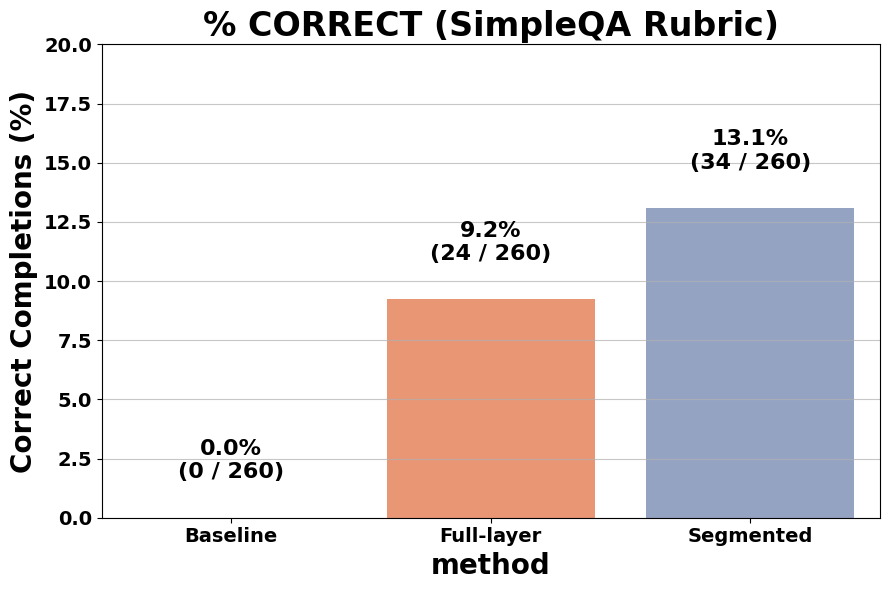

In [29]:
# Set larger global font sizes
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
})

# Create summary manually since baseline has 0 correct
data = {
    "method": ["Baseline", "Full-layer", "Segmented"],
    "correct": [0, 24, 34],
    "total": [260, 260, 260]
}
df_summary = pd.DataFrame(data)
df_summary["accuracy (%)"] = df_summary["correct"] / df_summary["total"] * 100

# Plot
plt.figure(figsize=(9, 6))
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
barplot = sns.barplot(data=df_summary, x="method", y="accuracy (%)", palette="Set2")

# Annotate each bar
for i, row in df_summary.iterrows():
    count_text = f"{row['correct']} / {row['total']}"
    acc_text = f"{row['accuracy (%)']:.1f}%"
    barplot.text(i, row["accuracy (%)"] + 1.5, f"{acc_text}\n({count_text})",
                 ha='center', va='bottom', fontsize=16, weight='bold')

# Final touches
plt.title("% CORRECT (SimpleQA Rubric)")
plt.ylabel("Correct Completions (%)")
plt.ylim(0, 20)  # Lower max to make differences visually sharper
plt.tight_layout()

# Save and show
plt.savefig("simpleqa_accuracy_barplot.png", dpi=300)
plt.show()

Segmented improved over Baseline by: 633.33%
Full-layer improved over Baseline by: 366.67%


<ipython-input-31-9b282933130f>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=acc_summary, x="method", y="accuracy (%)", palette="Set2")


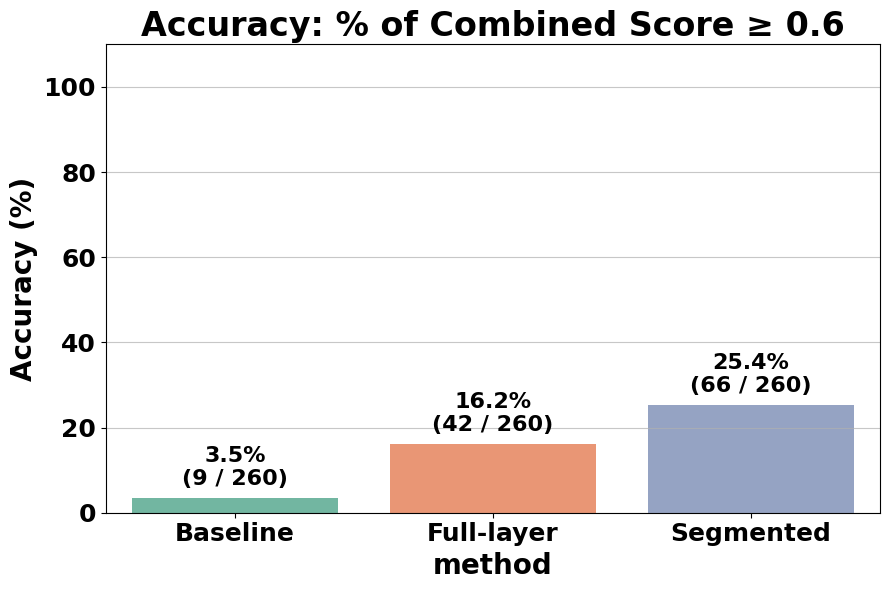

In [31]:
# Set larger global font sizes
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
})

# Calculate accuracy (≥ 0.6)
all_combined["accurate"] = all_combined["combined_score"].apply(lambda x: int(x >= 0.6))
acc_summary = all_combined.groupby("method")["accurate"].agg(["mean", "count", "sum"]).reset_index()
acc_summary["accuracy (%)"] = acc_summary["mean"] * 100

# Compute % improvement over baseline
baseline_acc = acc_summary.loc[acc_summary["method"] == "Baseline", "accuracy (%)"].values[0]
seg_acc = acc_summary.loc[acc_summary["method"] == "Segmented", "accuracy (%)"].values[0]
full_acc = acc_summary.loc[acc_summary["method"] == "Full-layer", "accuracy (%)"].values[0]

seg_improvement = (seg_acc - baseline_acc) / baseline_acc * 100
full_improvement = (full_acc - baseline_acc) / baseline_acc * 100

print(f"Segmented improved over Baseline by: {seg_improvement:.2f}%")
print(f"Full-layer improved over Baseline by: {full_improvement:.2f}%")

# Barplot with counts & labels
plt.figure(figsize=(9, 6))
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
barplot = sns.barplot(data=acc_summary, x="method", y="accuracy (%)", palette="Set2")

# Annotate bars with count of accurate cases
for i, row in acc_summary.iterrows():
    count_text = f"{int(row['sum'])} / {int(row['count'])}"
    acc_text = f"{row['accuracy (%)']:.1f}%"
    barplot.text(i, row["accuracy (%)"] + 2, f"{acc_text}\n({count_text})",
                 ha='center', va='bottom', fontsize=16)

plt.title("Accuracy: % of Combined Score ≥ 0.6")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 110)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='-', alpha=0.7)

# Save barplot
plt.savefig("accuracy_barplot.png", dpi=300)
plt.show()

<ipython-input-32-36323c3bb2aa>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


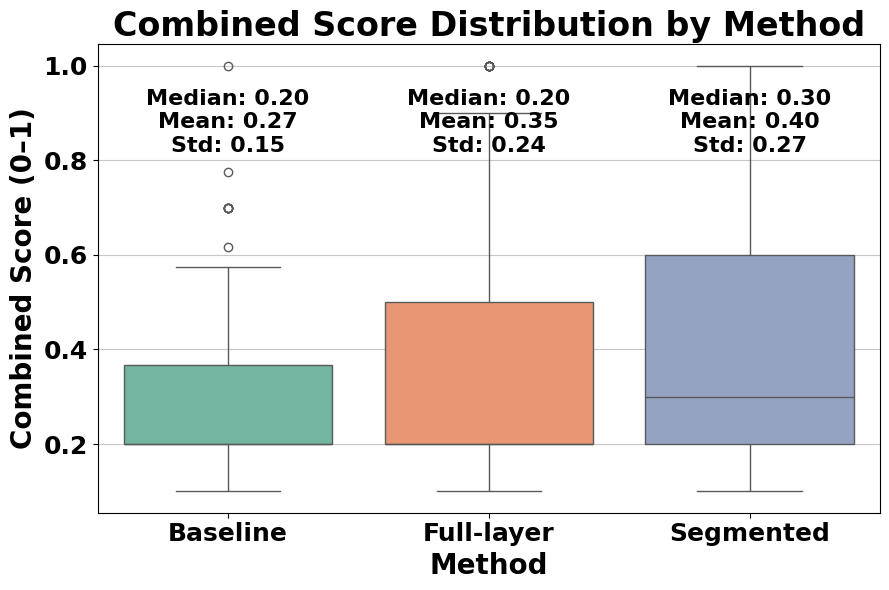

In [32]:
# Match color scheme from the bar chart
custom_palette = {
    "Baseline": "#66c2a5",     # green
    "Full-layer": "#fc8d62",   # orange
    "Segmented": "#8da0cb"     # blue/purple
}

# Set global font sizes
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
})

# Define order explicitly
method_order = ["Baseline", "Full-layer", "Segmented"]

# Compute stats
grouped = all_combined.groupby("method")["combined_score"]
medians = grouped.median().reindex(method_order)
means = grouped.mean().reindex(method_order)
stds = grouped.std().reindex(method_order)
whiskers = grouped.max().reindex(method_order)

# Plot
plt.figure(figsize=(9, 6))
ax = sns.boxplot(
    data=all_combined,
    x="method",
    y="combined_score",
    order=method_order,
    palette=custom_palette
)

plt.title("Combined Score Distribution by Method")
plt.ylabel("Combined Score (0–1)")
plt.xlabel("Method")
plt.grid(True, axis='y', linestyle='-', alpha=0.7)

# Annotate stats just below the top whisker
for i, method in enumerate(method_order):
    median_val = medians[method]
    mean_val = means[method]
    std_val = stds[method]
    top_y = whiskers[method] - 0.05
    label = (
        f"Median: {median_val:.2f}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Std: {std_val:.2f}"
    )
    plt.text(
        i, top_y, label,
        ha='center', va='top',
        fontsize=16, fontweight='bold'
    )

plt.tight_layout()
plt.savefig("combined_score_boxplot.png", dpi=300)
plt.show()

<ipython-input-34-46243cef6d84>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


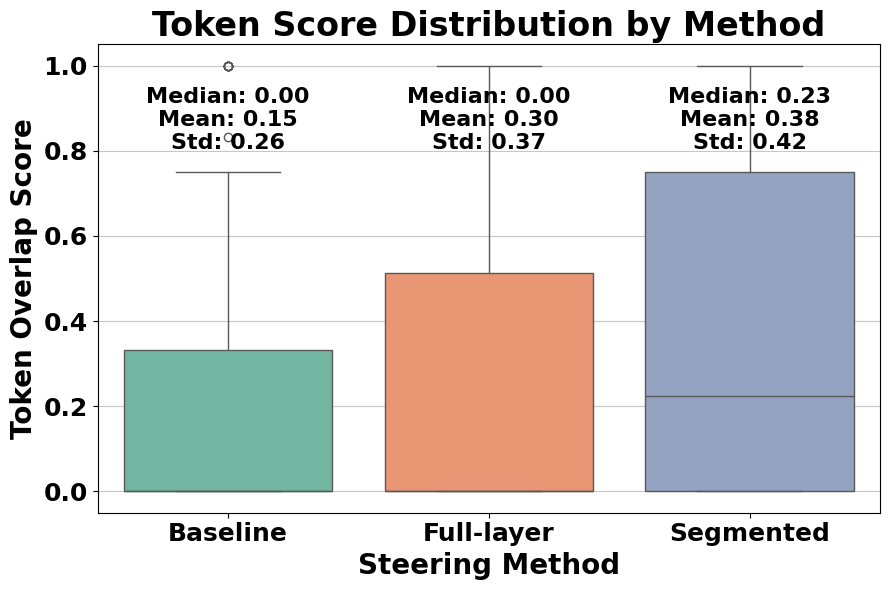

In [34]:
# Match color scheme
custom_palette = {
    "Baseline": "#66c2a5",     # green
    "Full-layer": "#fc8d62",   # orange
    "Segmented": "#8da0cb"     # blue/purple
}

method_order = ["Baseline", "Full-layer", "Segmented"]

# Set global font sizes
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
})

# Calculate summary stats
summary_stats = (
    all_combined.groupby("method")["token_overlap"]
    .agg(["mean", "median", "std"])
    .loc[method_order]
)

# Whisker top values for annotation placement
whiskers = all_combined.groupby("method")["token_overlap"].max().loc[method_order]

# Plot boxplot
plt.figure(figsize=(9, 6))
ax = sns.boxplot(
    data=all_combined,
    x="method",
    y="token_overlap",
    order=method_order,
    palette=custom_palette
)

# Annotate stats just below whiskers
for i, method in enumerate(method_order):
    median_val = summary_stats.loc[method, "median"]
    mean_val = summary_stats.loc[method, "mean"]
    std_val = summary_stats.loc[method, "std"]
    top_y = whiskers[method] - 0.05

    label = (
        f"Median: {median_val:.2f}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Std: {std_val:.2f}"
    )
    plt.text(
        i, top_y, label,
        ha='center', va='top',
        fontsize=16, fontweight='bold'
    )

plt.title("Token Score Distribution by Method")
plt.ylabel("Token Overlap Score")
plt.xlabel("Steering Method")
plt.grid(True, axis='y', linestyle='-', alpha=0.7)
plt.tight_layout()
plt.savefig("token_overlap_boxplot.png", dpi=300)
plt.show()

<ipython-input-35-177054219f07>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_summary, x="method", y="accuracy (%)", palette="Set2")
<ipython-input-35-177054219f07>:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, fontweight='bold')
<ipython-input-35-177054219f07>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=18, fontweight='bold')


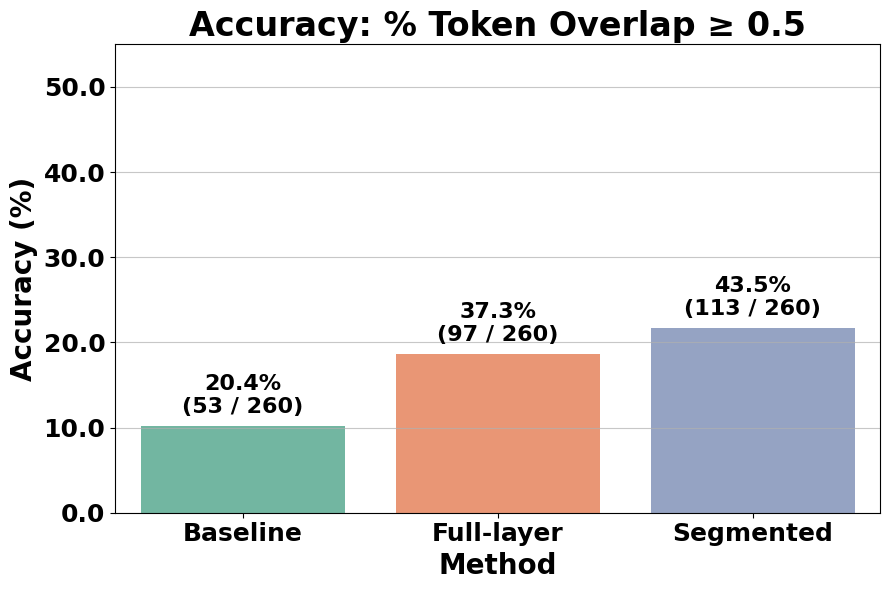

In [35]:
# Mark examples with token overlap ≥ 0.5 as accurate
all_combined["accurate"] = all_combined["token_overlap"].apply(lambda x: int(x >= 0.5))

# Compute accuracy summary
acc_summary = all_combined.groupby("method").agg(
    correct=("accurate", "sum"),
    total=("accurate", "count")
).reset_index()
acc_summary["accuracy (%)"] = acc_summary["correct"] / acc_summary["total"] * 100

# Global font config
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.titleweight': 'bold',
    'axes.labelsize': 20,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'font.weight': 'bold',
    'legend.fontsize': 16,
    'legend.title_fontsize': 18
})

# Plot
plt.figure(figsize=(9, 6))
ax = sns.barplot(data=acc_summary, x="method", y="accuracy (%)", palette="Set2")

# Annotate bars
for i, row in acc_summary.iterrows():
    label = f"{row['accuracy (%)']:.1f}%\n({int(row['correct'])} / {int(row['total'])})"
    ax.text(i, row["accuracy (%)"] + 2, label, ha="center", va="bottom", fontsize=16, fontweight='bold')

# Axis labels and title
plt.title("Accuracy: % Token Overlap ≥ 0.5", fontsize=24, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=20, fontweight='bold')
plt.xlabel("Method", fontsize=20, fontweight='bold')

# Ticks
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=18, fontweight='bold')

plt.ylim(0, 110)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.tight_layout()

# Save
plt.savefig("token_overlap_accuracy_barplot.png", dpi=300)
plt.show()

In [39]:
# Set aesthetics
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Load all CSVs
baseline_df = pd.read_csv("mistral_grader_results_baseline_with_score_and_overlap.csv")
full_grades = pd.read_csv("mistral_grader_results_full_merged.csv")
seg_df = pd.read_csv("mistral_grader_results_segmented.csv")

# Add method labels
baseline_df["method"] = "Baseline"
full_grades["method"] = "Full-layer Steering"
seg_df["method"] = "Segmented Steering"

# Rename for consistency
baseline_df = baseline_df.rename(columns={"prompt_id": "prompt_idx"})
seg_df = seg_df.rename(columns={"prompt_id": "prompt_idx"})
full_grades = full_grades.rename(columns={"prompt_idx": "prompt_idx"})  # already good

# Keep only necessary columns
baseline_df = baseline_df[["prompt_idx", "score", "method"]]
full_grades = full_grades[["prompt_idx", "score", "method"]]
seg_df = seg_df[["prompt_idx", "score", "method"]]

# Combine
combined_df = pd.concat([baseline_df, full_grades, seg_df], ignore_index=True)

# Keep only best score per prompt per method
combined_df = combined_df.sort_values("score", ascending=False).drop_duplicates(subset=["prompt_idx", "method"])

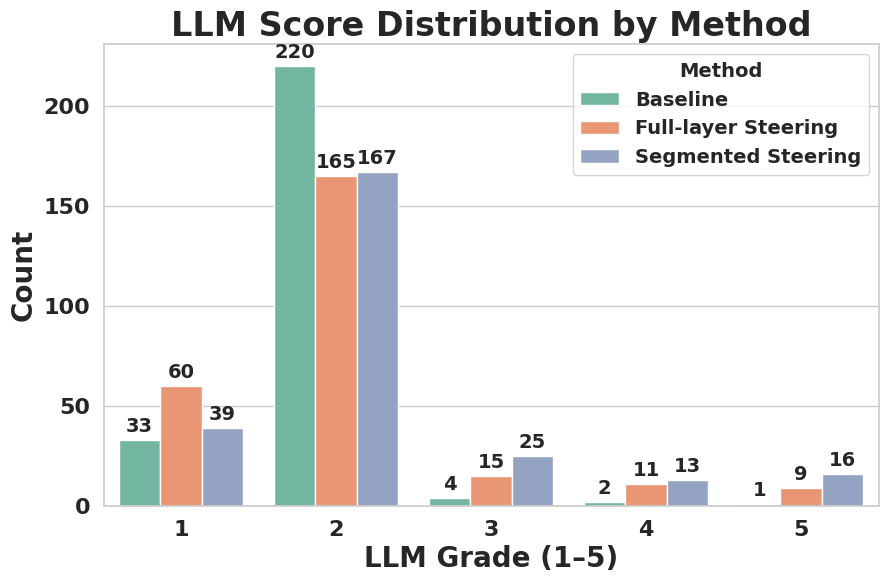

In [40]:
# Define consistent custom colors
custom_palette = {
    "Baseline": "#66c2a5",             # green
    "Full-layer Steering": "#fc8d62",  # orange
    "Segmented Steering": "#8da0cb"    # blue/purple
}

# Set font sizes globally
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'legend.title_fontsize': 18
})

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the countplot
ax = sns.countplot(
    data=combined_df,
    x="score",
    hue="method",
    palette=custom_palette,
    hue_order=["Baseline", "Full-layer Steering", "Segmented Steering"]
)

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=14, fontweight='bold')

# Final formatting
plt.title("LLM Score Distribution by Method", fontsize=24, fontweight='bold')
plt.xlabel("LLM Grade (1–5)", fontsize=20, fontweight='bold')
plt.ylabel("Count", fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

legend = plt.legend(title="Method", fontsize=14, title_fontsize=14)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Save the figure
plt.savefig("llm_score_countplot.png", dpi=300)
plt.show()

<ipython-input-41-4568690203b8>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=llm_acc, x="method", y="accuracy (%)", palette="Set2")


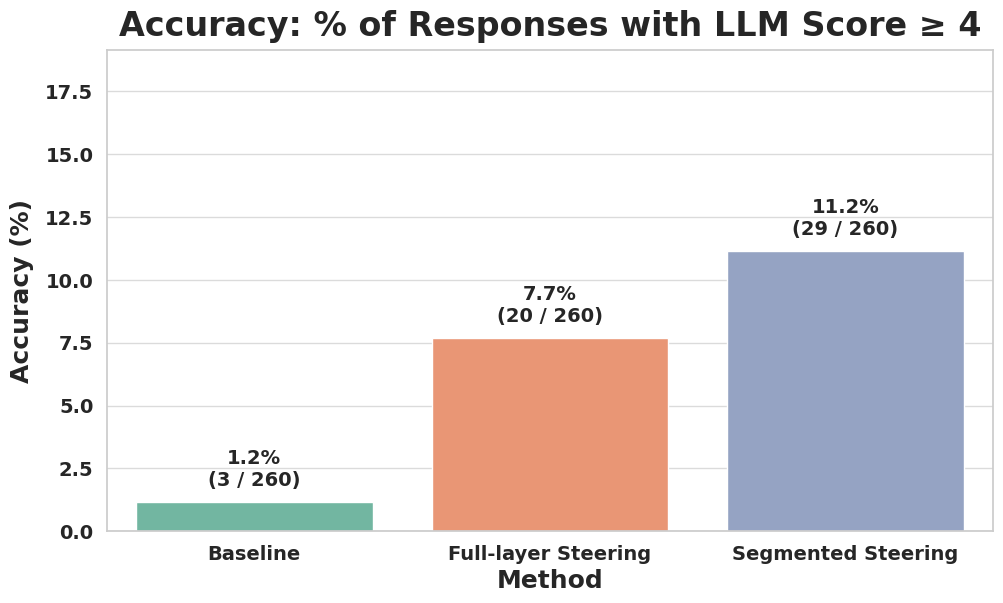

In [41]:
def binarize(score):
    return int(score >= 4)

acc_df = combined_df.copy()
acc_df["is_correct"] = acc_df["score"].apply(binarize)

# Compute accuracy + counts
llm_acc = acc_df.groupby("method").agg(
    correct=("is_correct", "sum"),
    total=("is_correct", "count")
).reset_index()
llm_acc["accuracy (%)"] = llm_acc["correct"] / llm_acc["total"] * 100

# Plot
plt.figure(figsize=(10, 6))  # Slightly reduced height
sns.set(style="whitegrid")

ax = sns.barplot(data=llm_acc, x="method", y="accuracy (%)", palette="Set2")

# Add % and count annotations just above the bar
for i, row in llm_acc.iterrows():
    label = f"{row['accuracy (%)']:.1f}%\n({int(row['correct'])} / {int(row['total'])})"
    ax.text(
        i, row["accuracy (%)"] + 0.5,
        label,
        ha="center", va="bottom",
        fontsize=14, fontweight='bold'
    )

# Bold styling and font control
plt.title("Accuracy: % of Responses with LLM Score ≥ 4", fontsize=24, fontweight='bold', pad=10)
plt.ylabel("Accuracy (%)", fontsize=18, fontweight='bold', labelpad=8)
plt.xlabel("Method", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Tighter y-axis upper bound
plt.ylim(0, max(llm_acc["accuracy (%)"]) + 8)

plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.tight_layout(pad=0.5)

# Save to file
plt.savefig("llm_accuracy_barplot.png", dpi=300)
plt.show()